In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler


/Users/shrutikaushal/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
os.getcwd()

'/Users/shrutikaushal/Documents/GitHub/Prediction-of-commercial-insurance-payments-for-surgical-procedure-using-DataRobot'

In [3]:
path = os.getcwd()

In [4]:
group_df = pd.read_excel(path+
    '/Data_Files/JnJ_Files/cost_discharge_physpec_ippct.xlsx')

In [5]:
group_df.head()

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct
0,ankle_fix,16741.5136,0.621714,ORTHOPEDIC SURGERY (ORS),0.542798
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543
3,bariatric,14585.5550,0.945035,GENERAL SURGERY (GS),0.911311
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127


In [6]:
group_df.phy_spec.unique()

array(['ORTHOPEDIC\xa0SURGERY\xa0(ORS)',
       'NEUROLOGICAL\xa0SURGERY\xa0(NS)', 'GENERAL\xa0SURGERY\xa0(GS)',
       'PLASTIC\xa0SURGERY\xa0(PS)', 'OTOLARYNGOLOGY\xa0(OTO)',
       'PODIATRY\xa0(POD)', 'CARDIOVASCULAR\xa0DISEASES\xa0(CD)',
       'CARDIAC\xa0ELECTROPHYSIOLOGY\xa0(ICE)', 'HOSPITALIST\xa0(HOS)',
       'OBSTETRICS/GYNECOLOGY\xa0(OBG)', 'INTERNAL\xa0MEDICINE\xa0(IM)',
       'UROLOGY\xa0(U)', 'THORACIC\xa0SURGERY\xa0(TS)'], dtype=object)

In [7]:
# normalizing features
m = StandardScaler()
norm_group_df = group_df.copy()[['pat_cost','discharge_to_home_pct','IP_pct']]

norm_group_df = m.fit_transform(norm_group_df.values)
norm_group_df = pd.DataFrame(norm_group_df)
norm_group_df.columns = ['pat_cost','discharge_to_home_pct','IP_pct']

### Visualizing the numerical features

<IPython.core.display.Javascript object>


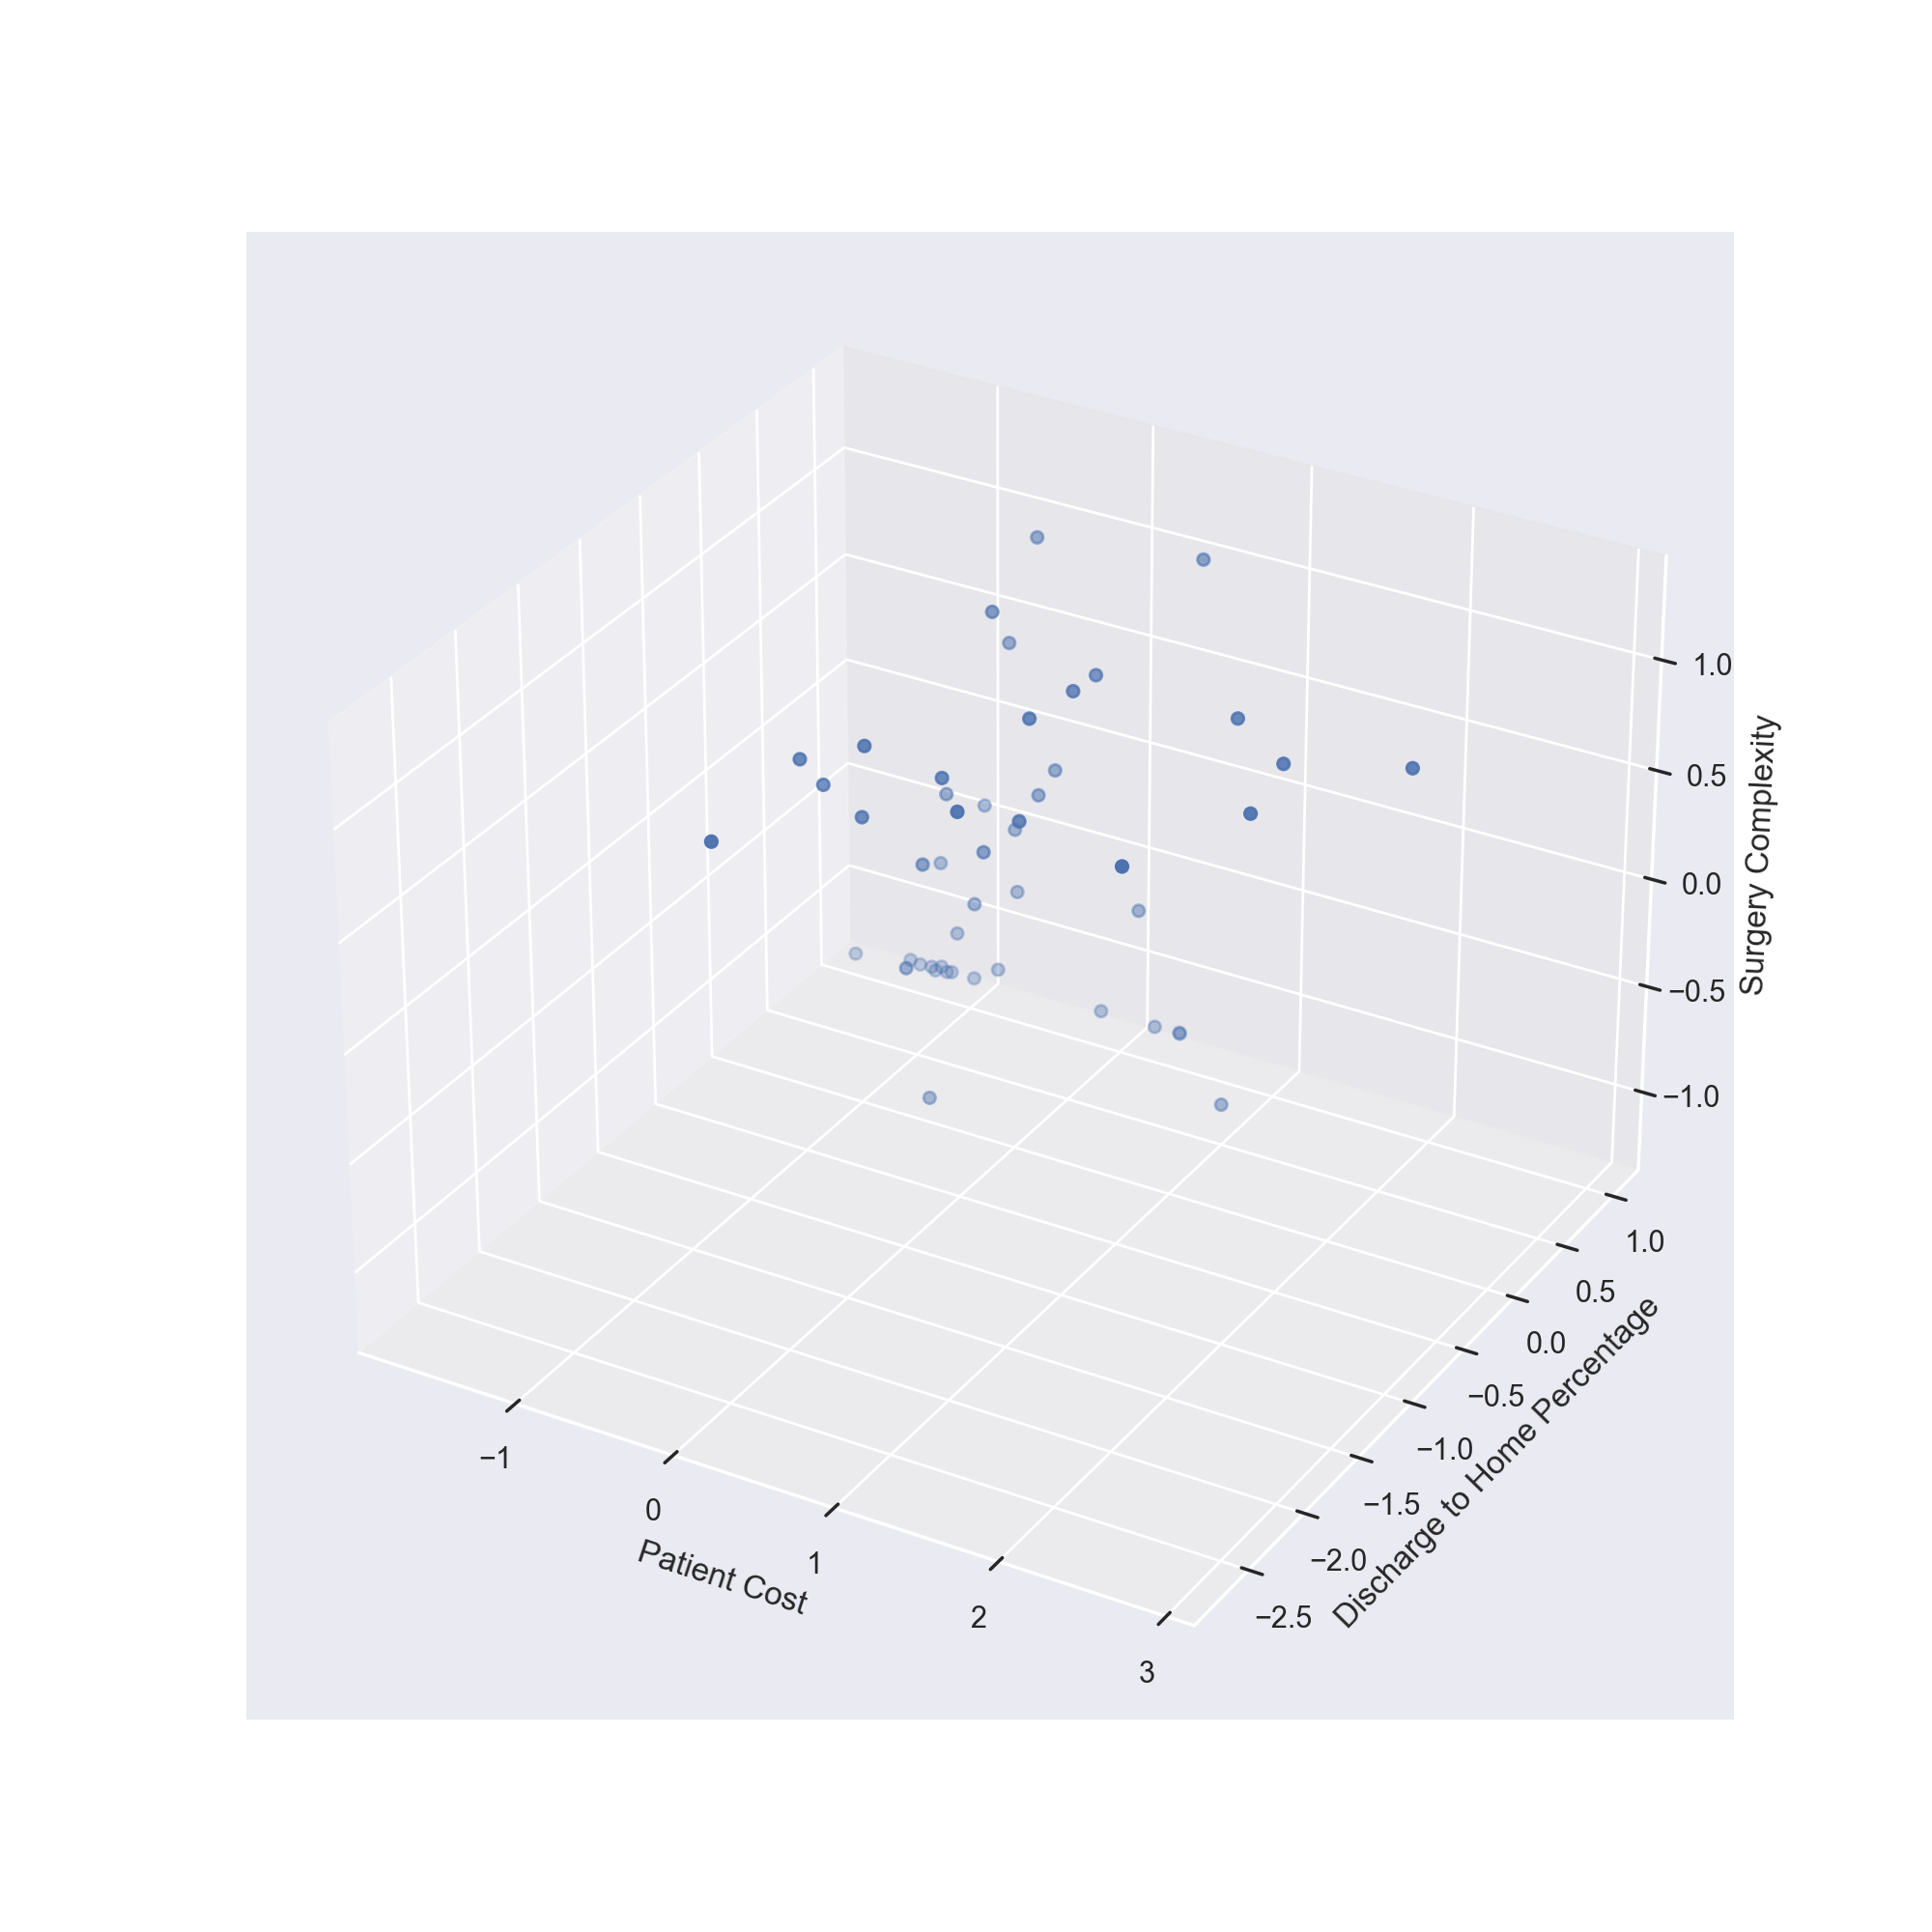

In [8]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = '3d')

x = norm_group_df['pat_cost']
y = norm_group_df['discharge_to_home_pct']
z = norm_group_df['IP_pct']

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z)

plt.show()


### Performing preliminary clustering

#### K-MEANS

In [9]:
X = group_df[['pat_cost','discharge_to_home_pct','IP_pct']].values

In [10]:
# determining the optimal number of clusters
clusters = np.arange(1,10)
inertia = []
for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X)
    inertia.append(model.inertia_)

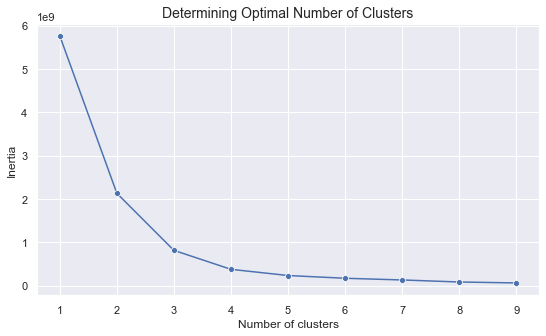

In [11]:
%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

##### Optimal number of clusters = 3

In [12]:
optimal_model = KMeans(n_clusters = 3).fit_predict(X)

In [13]:
cluster_df = group_df.copy()
cluster_df['cluster'] = optimal_model

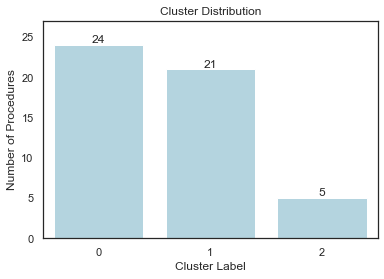

In [14]:
sns.set_theme(style='white')
plt.figure(figsize = (6,4))
ax = sns.barplot(x = 'cluster', y = 0, data = cluster_df.groupby(by = 'cluster').size().reset_index(),\
            color = 'lightblue')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.set_title('Cluster Distribution')
ax.set_ylabel('Number of Procedures')
ax.set_xlabel('Cluster Label')
# plt.savefig(path+'/figures/kmeans_optimal_clusters_barplot.png', bbox_inches = 'tight')
plt.show()

In [15]:
cluster_df[cluster_df.cluster == 0][['group']].to_csv(path+'/group0.csv', index=False)

In [16]:
cluster_df.groupby(by = ['cluster','phy_spec']).size().reset_index()

,cluster,phy_spec,0
0,0,CARDIAC ELECTROPHYSIOLOGY (ICE),1
1,0,CARDIOVASCULAR DISEASES (CD),6
2,0,GENERAL SURGERY (GS),2
3,0,HOSPITALIST (HOS),2
4,0,INTERNAL MEDICINE (IM),2
5,0,NEUROLOGICAL SURGERY (NS),1
6,0,ORTHOPEDIC SURGERY (ORS),9
7,0,THORACIC SURGERY (TS),1
8,1,GENERAL SURGERY (GS),5
9,1,OBSTETRICS/GYNECOLOGY (OBG),1


<IPython.core.display.Javascript object>


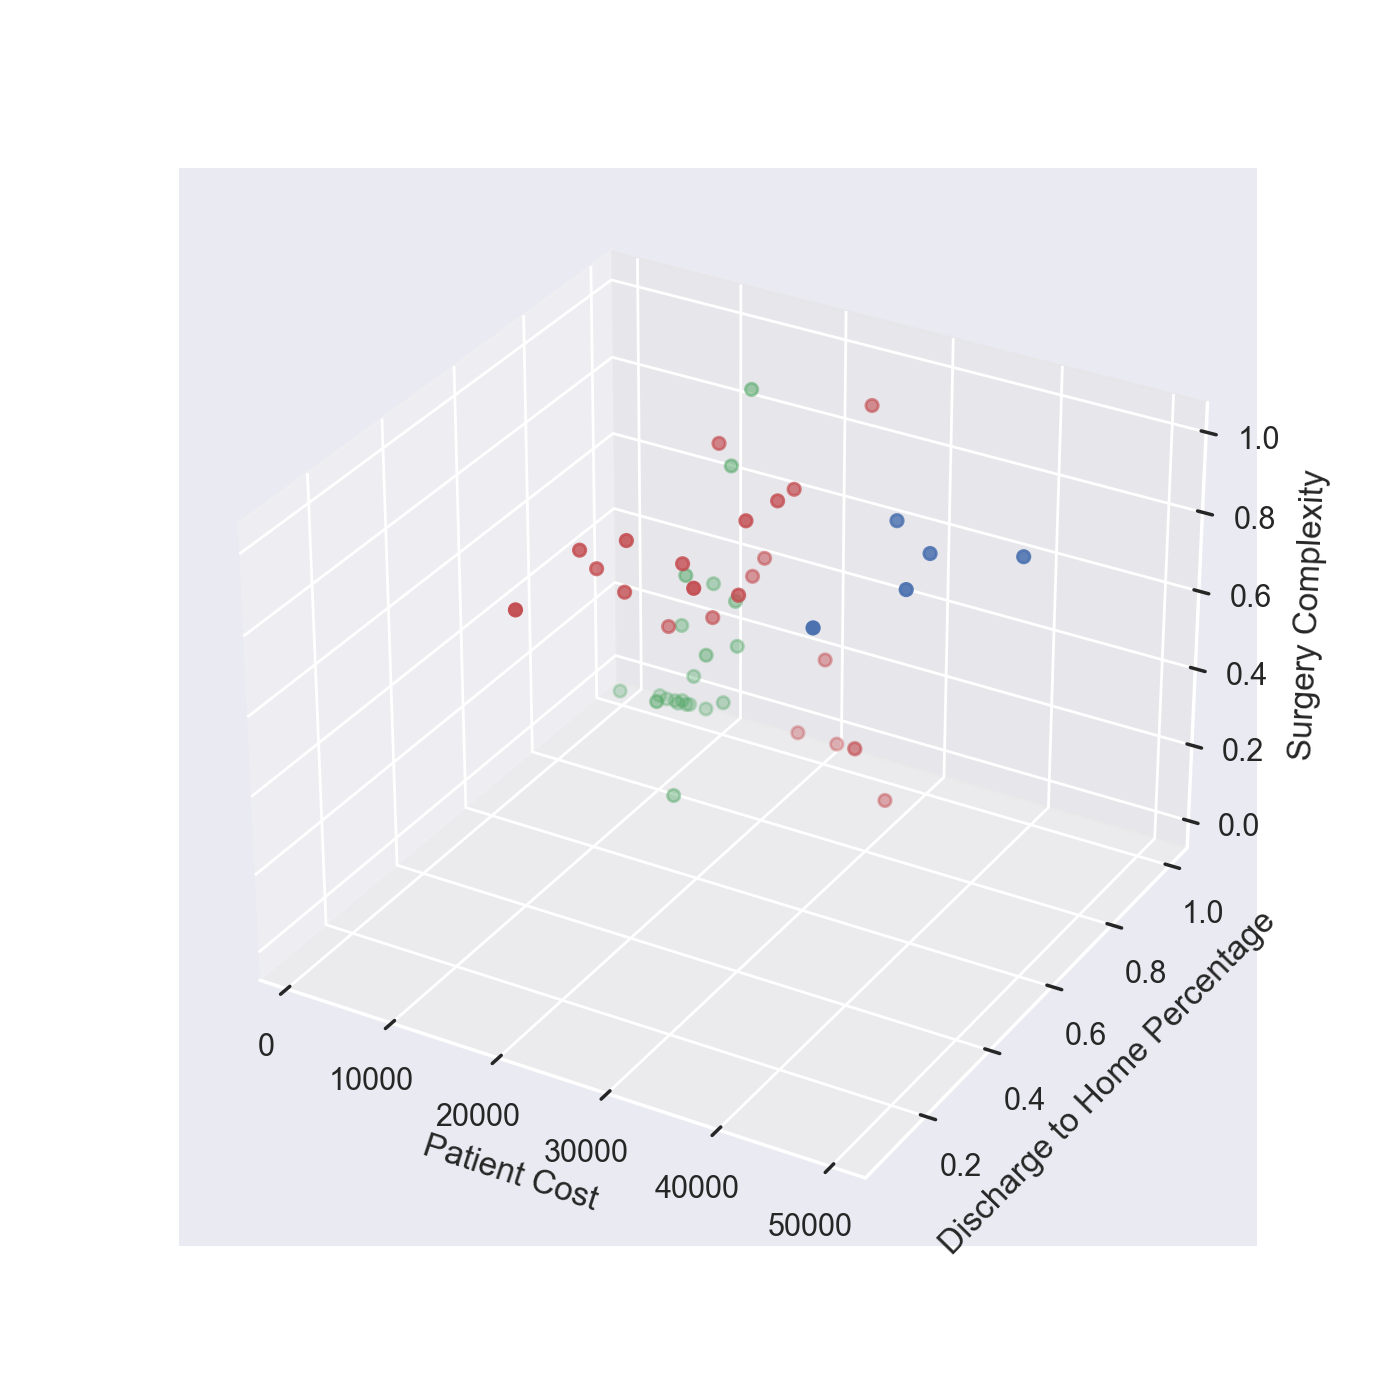

In [17]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection = '3d')

x = cluster_df['pat_cost']
y = cluster_df['discharge_to_home_pct']
z = cluster_df['IP_pct']

col=cluster_df['cluster'].map({0:'r',1:'g',2:'b'})

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z, color = col)

plt.show()

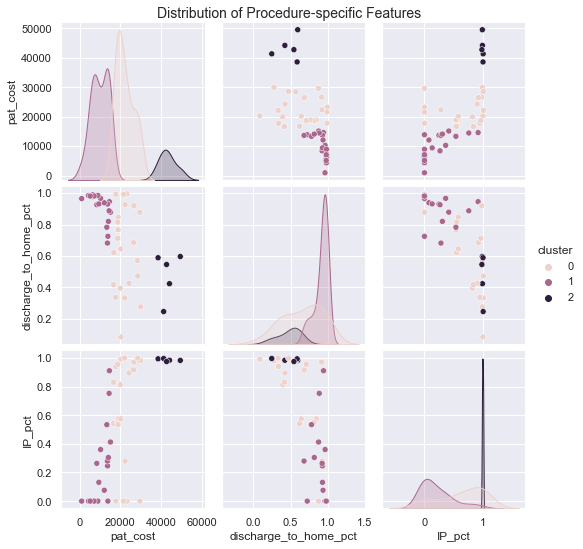

In [18]:
%matplotlib inline
f = sns.pairplot(cluster_df, hue = 'cluster')
f.fig.suptitle('Distribution of Procedure-specific Features', y = 1.01, fontsize = 14)
#plt.savefig(path+'/figures/pairplotFeatures_kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

### Normalized KMeans

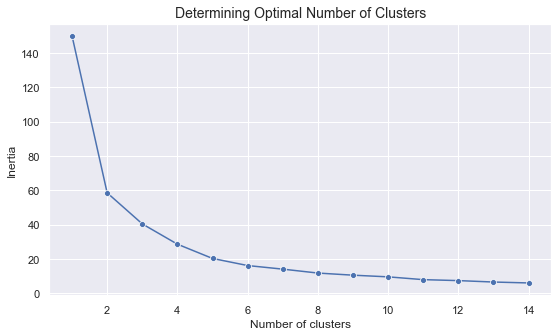

In [19]:
X = norm_group_df[['pat_cost','discharge_to_home_pct','IP_pct']].values
# determining the optimal number of clusters
clusters = np.arange(1,15)
inertia = []
for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X)
    inertia.append(model.inertia_)
    

%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

##### Optimal number of clusters = 3

In [20]:
num_clusters = 3
optimal_model = KMeans(n_clusters = num_clusters, random_state = 0).fit_predict(X)

In [21]:
cluster_df = group_df.copy()
cluster_df['cluster'] = optimal_model

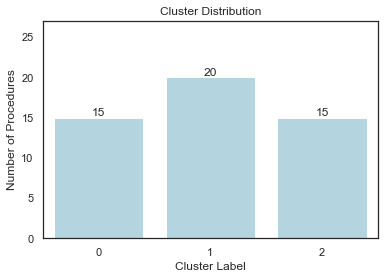

In [22]:
sns.set_theme(style='white')
plt.figure(figsize = (6,4))
ax = sns.barplot(x = 'cluster', y = 0, data = cluster_df.groupby(by = 'cluster').size().reset_index(),\
            color = 'lightblue')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.set_title('Cluster Distribution')
ax.set_ylabel('Number of Procedures')
ax.set_xlabel('Cluster Label')
# plt.savefig(path+'/figures/kmeans_optimal_clusters_barplot.png', bbox_inches = 'tight')
plt.show()

<IPython.core.display.Javascript object>


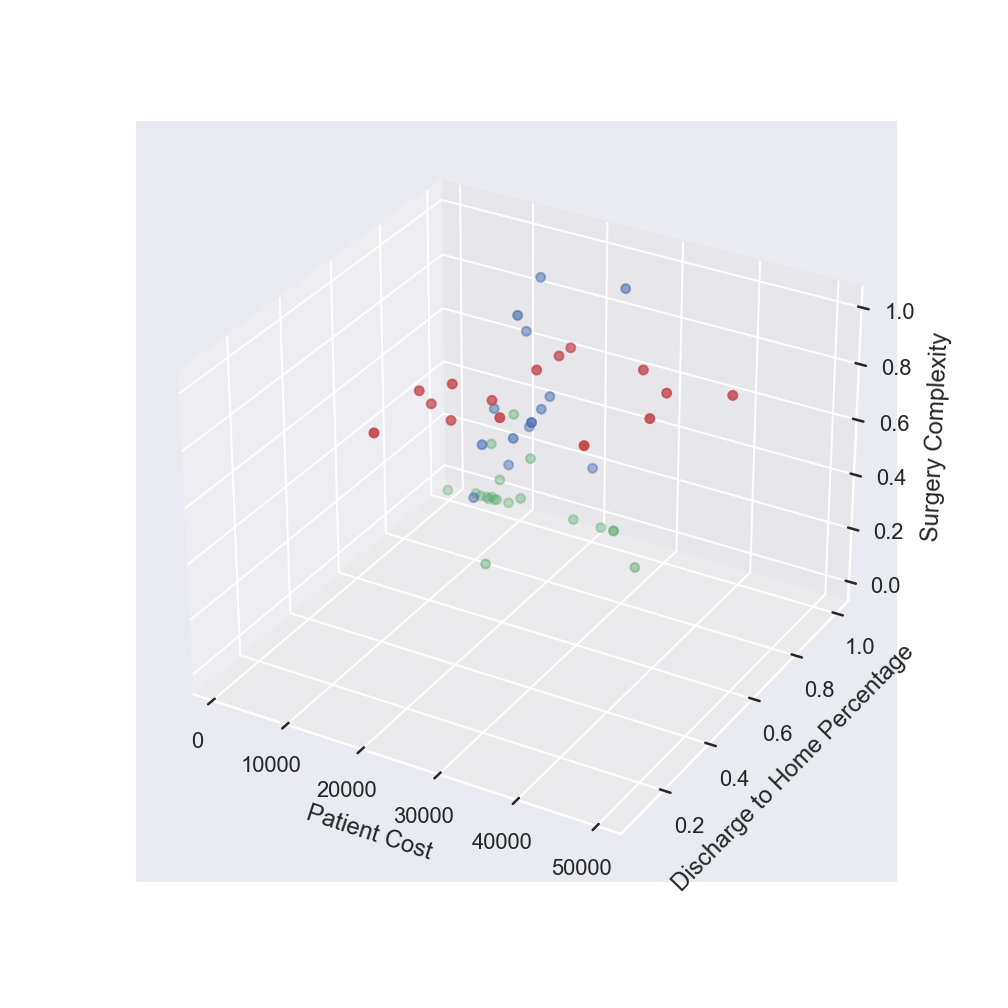

In [23]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection = '3d')

x = cluster_df['pat_cost']
y = cluster_df['discharge_to_home_pct']
z = cluster_df['IP_pct']

col=cluster_df['cluster'].map({0:'r',1:'g',2:'b',3:'y',4:'black'})

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z, color = col)

plt.show()

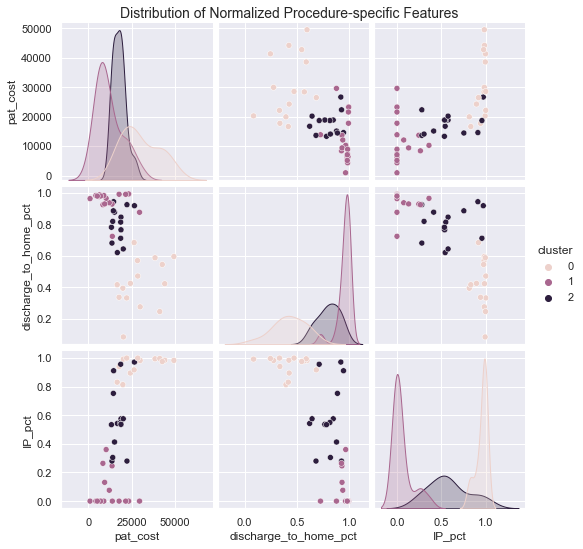

In [24]:
%matplotlib inline
f = sns.pairplot(cluster_df, hue = 'cluster')
f.fig.suptitle('Distribution of Normalized Procedure-specific Features', y = 1.01, fontsize = 14)
plt.savefig(path+'/figures/pairplotFeatures_kmeans_optimal_normClusters.png', bbox_inches = 'tight')
plt.show()

In [25]:
path

'/Users/shrutikaushal/Documents/GitHub/Prediction-of-commercial-insurance-payments-for-surgical-procedure-using-DataRobot'

In [166]:
for i in range(num_clusters):
    cluster_df[cluster_df.cluster == i][['group']].to_csv(path+'/Kmeans_clusters/standardized/group'+
                                                          str(i)+'.csv', index=False)

In [26]:
cluster_df['group'] = list(map(lambda s: s.replace('\xa0',' '), cluster_df['group'].to_list()))

#### Plotting data points in each cluster

In [27]:
data = pd.read_csv(path+
    '/Data_Files/JnJ_Files/priv_mcare_f_pay_2022Oct18.csv')

##### There are 2 procedures that are not in the procedure data shared with us

In [35]:
set(data.group)-set(cluster_df.group)

{'bdet', 'post_TLS_fusion'}

In [93]:
merged_data = pd.merge(data, cluster_df[['group','cluster']].drop_duplicates(), 
                       left_on = 'group', right_on = 'group')

In [94]:
# applying some preprocessing
merged_data.dropna(subset = 'priv_pay_median', inplace = True)
merged_data = merged_data[merged_data.priv_count != 0]
merged_data = merged_data[merged_data.priv_pay_median > 1]

In [95]:
merged_data = merged_data[merged_data.priv_count>=51]

In [90]:
m = MinMaxScaler()
merged_data['norm_priv_pay_median'] = m.fit_transform(merged_data['priv_pay_median'].values.reshape(-1,1))
merged_data['norm_mcare_pay_median'] = m.fit_transform(merged_data['mcare_pay_median'].values.reshape(-1,1))

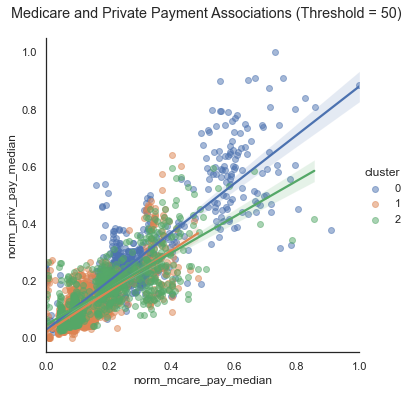

In [91]:
sns.set_theme(style='white')
g = sns.lmplot(x = 'norm_mcare_pay_median', y = 'norm_priv_pay_median', hue = 'cluster',
                data = merged_data, scatter_kws = {'alpha':0.5})
g.fig.suptitle('Medicare and Private Payment Associations (Threshold = 50)', y = 1.05)
plt.savefig(path+'/figures/RregressionPayDist_kmeans_optimal_normClusters.png', bbox_inches = 'tight')
plt.show()

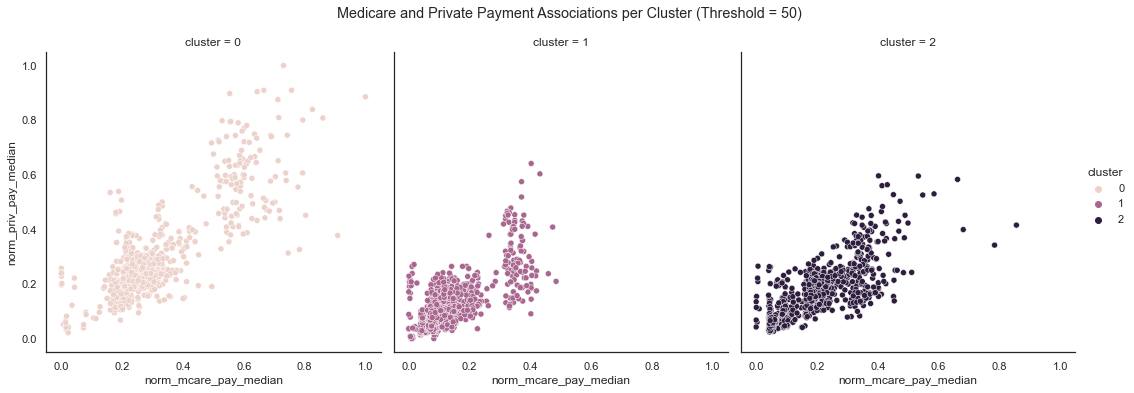

In [92]:
sns.set_theme(style='white')
g = sns.relplot(x = 'norm_mcare_pay_median', y = 'norm_priv_pay_median', col = 'cluster', hue = 'cluster',
                data = merged_data)
g.fig.suptitle('Medicare and Private Payment Associations per Cluster (Threshold = 50)', y = 1.05)
plt.savefig(path+'/figures/FilteredPayDist_kmeans_optimal_normClusters.png', bbox_inches = 'tight')
plt.show()

In [105]:
merged_data[merged_data.cluster == 2].shape

(830, 18)

In [101]:
merged_data.shape

(4219, 18)